In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras import Sequential
from keras.layers import Input, Dense, Embedding, GlobalMaxPool1D, Dropout
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [69]:
filepath_dict = {'yelp':   'sentiment-analysis/yelp_labelled.txt',
                 'amazon': 'sentiment-analysis/amazon_cells_labelled.txt',
                 'imdb':   'sentiment-analysis/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [56]:
df.tail()

,sentence,label,source
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb
747,All in all its an insult to one's intelligence...,0,imdb


In [9]:
sentences = ['John likes ice cream', 'John hates chocolate.']

In [16]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [18]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]], dtype=int64)

In [87]:
df_yelp = df[df['source']=='yelp']
sentences = df_yelp['sentence'].values
labels = df_yelp['label'].values
X_train_yelp, X_test_yelp, y_train_yelp, y_test_yelp = train_test_split(sentences, labels, test_size=0.25, random_state=42)

In [41]:
X_train

<750x1728 sparse matrix of type '<class 'numpy.int64'>'
	with 7387 stored elements in Compressed Sparse Row format>

In [88]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train_yelp)

X_train_yelp = vectorizer.transform(X_train_yelp)
X_test_yelp = vectorizer.transform(X_test_yelp)

In [5]:
for source in df['source'].unique():

    df_source = df[df['source']==source]
    sentences = df_source['sentence'].values
    labels = df_source['label'].values

    X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25, random_state=42)

    vectorizer = CountVectorizer()
    vectorizer.fit(X_train)

    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    print(f'{source:10s}: {classifier.score(X_test, y_test):.3f}')

yelp      : 0.816
amazon    : 0.844
imdb      : 0.727


In [3]:
df_source = df[df['source']=='yelp']
sentences = df_source['sentence'].values
labels = df_source['label'].values
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [4]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],), name='input_text'),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                17290     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 17,301
Trainable params: 17,301
Non-trainable params: 0
_________________________________________________________________


In [5]:
%%time

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=10,
    verbose=2,
    validation_data=(X_test, y_test)
)

Epoch 1/10
75/75 - 2s - loss: 0.6830 - accuracy: 0.5773 - val_loss: 0.6678 - val_accuracy: 0.6640
Epoch 2/10
75/75 - 0s - loss: 0.6172 - accuracy: 0.7933 - val_loss: 0.6243 - val_accuracy: 0.7400
Epoch 3/10
75/75 - 0s - loss: 0.5213 - accuracy: 0.8840 - val_loss: 0.5728 - val_accuracy: 0.7680
Epoch 4/10
75/75 - 0s - loss: 0.4187 - accuracy: 0.9253 - val_loss: 0.5243 - val_accuracy: 0.7960
Epoch 5/10
75/75 - 0s - loss: 0.3291 - accuracy: 0.9587 - val_loss: 0.4855 - val_accuracy: 0.8120
Epoch 6/10
75/75 - 0s - loss: 0.2606 - accuracy: 0.9680 - val_loss: 0.4584 - val_accuracy: 0.8040
Epoch 7/10
75/75 - 0s - loss: 0.2072 - accuracy: 0.9787 - val_loss: 0.4405 - val_accuracy: 0.8080
Epoch 8/10
75/75 - 0s - loss: 0.1667 - accuracy: 0.9853 - val_loss: 0.4263 - val_accuracy: 0.8120
Epoch 9/10
75/75 - 0s - loss: 0.1365 - accuracy: 0.9907 - val_loss: 0.4190 - val_accuracy: 0.8160
Epoch 10/10
75/75 - 0s - loss: 0.1124 - accuracy: 0.9933 - val_loss: 0.4172 - val_accuracy: 0.8200
CPU times: user 2.9

In [6]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9947
Testing Accuracy:  0.8200


In [7]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))
    fig.subplots_adjust(hspace=0.5)
    
    ax1.plot(history['loss'], label='loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['accuracy'], label='Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

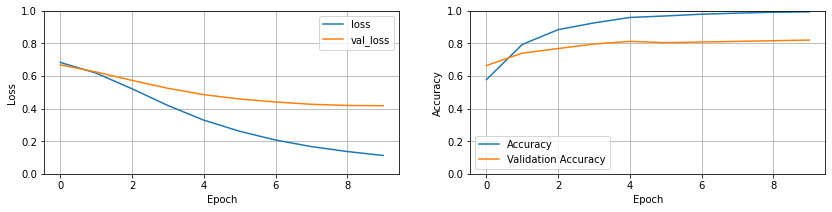

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist
plot_history(hist)

In [68]:
clear_session()

In [18]:
cities = ['London','Brussels','Brussels','London','New York']
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 1, 2], dtype=int64)

In [20]:
encoder_onehot = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((-1,1))
encoder_onehot.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [70]:
# Prep for embeddings
# df_source = df[df['source']=='yelp']
# sentences = df_source['sentence'].values
# labels = df_source['label'].values

sentences = df['sentence'].values
labels = df['label'].values
X_sentences_train, X_sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25, random_state=42)

In [71]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_sentences_train)

X_train = tokenizer.texts_to_sequences(X_sentences_train)
X_test = tokenizer.texts_to_sequences(X_sentences_test)

vocab_size = len(tokenizer.word_index) + 1


In [72]:
print(X_sentences_train[223])
print(X_train[223])

Good beer & drink selection and good food selection.
[18, 621, 728, 345, 2, 18, 34, 345]


In [73]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [31]:
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           87850     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 88,371
Trainable params: 88,371
Non-trainable params: 0
_________________________________________________________________


In [80]:
%%time

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/50
207/207 - 1s - loss: 0.7018 - accuracy: 0.5429 - val_loss: 0.6691 - val_accuracy: 0.6041
Epoch 2/50
207/207 - 1s - loss: 0.6494 - accuracy: 0.6230 - val_loss: 0.6373 - val_accuracy: 0.6419
Epoch 3/50
207/207 - 1s - loss: 0.5884 - accuracy: 0.7079 - val_loss: 0.5888 - val_accuracy: 0.7016
Epoch 4/50
207/207 - 1s - loss: 0.5146 - accuracy: 0.7467 - val_loss: 0.5222 - val_accuracy: 0.7438
Epoch 5/50
207/207 - 1s - loss: 0.4232 - accuracy: 0.8151 - val_loss: 0.4893 - val_accuracy: 0.7671
Epoch 6/50
207/207 - 1s - loss: 0.3576 - accuracy: 0.8501 - val_loss: 0.4640 - val_accuracy: 0.7627
Epoch 7/50
207/207 - 1s - loss: 0.2896 - accuracy: 0.8918 - val_loss: 0.4484 - val_accuracy: 0.7773
Epoch 8/50
207/207 - 1s - loss: 0.2424 - accuracy: 0.9117 - val_loss: 0.4417 - val_accuracy: 0.8006
Epoch 9/50
207/207 - 1s - loss: 0.2046 - accuracy: 0.9262 - val_loss: 0.4441 - val_accuracy: 0.8049
Epoch 10/50
207/207 - 1s - loss: 0.1705 - accuracy: 0.9418 - val_loss: 0.4509 - val_accuracy: 0.7962

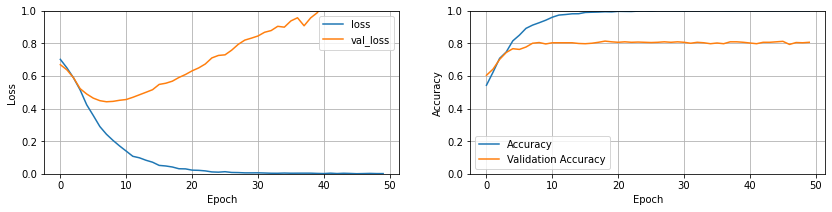

In [81]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist
plot_history(hist)

In [74]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [75]:
embedding_matrix = create_embedding_matrix(
    'glove/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [79]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen,
                    weights=[embedding_matrix], 
                    trainable=True))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           221600    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 222,121
Trainable params: 222,121
Non-trainable params: 0
_________________________________________________________________
